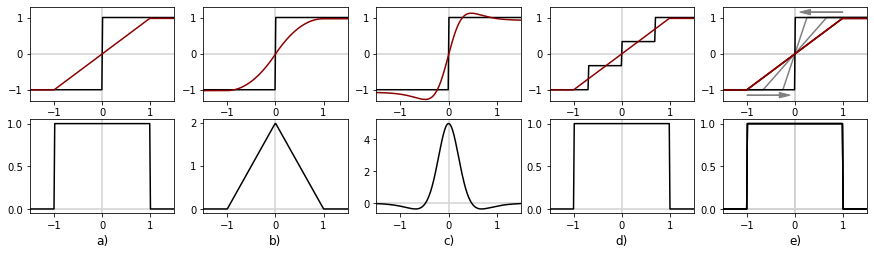

In [40]:
from typing import List, Callable

from bitorch.quantizations import Sign, SwishSign, SteHeaviside, ApproxSign, ProgressiveSign, InputDoReFa, WeightDoReFa
from bitorch.layers import QActivation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
import torch


LABEL_POS = -0.4

def calculate_numeric_gradient(x_values: np.array, y_values: np.array, x_step_size: float):
    # :param x_values: a list of equidistant x values
    # :param y_values: the list of corresponding y values for an unknown function
    # :param x_step_size: the fixed distance between two consecutive x values
    # :return: a list of numeric gradients for each step in the function (with one less element than the given x_values)

    # initialize a numpy array with the correct size
    numeric_gradient = np.zeros(len(x_values) - 1)

    # TODO: calculate the numeric gradient between each consecutive pair of x values based on the given y values
    ### BEGIN SOLUTION
    for i in range(1, len(x_values)):
        numeric_gradient[i-1] = (y_values[i] - y_values[i-1]) / x_step_size
    ### END SOLUTION
    return numeric_gradient


def reconstruct_gradient_function(x_grad_values: np.array, x_step_size: float, y_offset=0.0):
    # :param x_grad_values: a list of calculated gradients (based on step size `x_step_size`)
    # :param x_step_size: the distance between two consecutive x values that was used to calculate `x_grad_values`
    # :return: a list of y values for a (representative) function that would create the given gradient values
    #          (the y_values should be zero at the middle element)

    # intialize an array with the correct size
    y_values = np.zeros(len(x_grad_values))

    # TODO: construct a list of y values for a (representative) function that would create the given gradient values
    # HINT: start with any arbitrary value, create y_values step by step, finally subtract something from all values so the middle element becomes zero
    ### BEGIN SOLUTION
    y_values[0] = 0
    for i in range(1, len(x_grad_values)):
        y_values[i] = y_values[i-1] + x_grad_values[i] * x_step_size
    y_values -= y_values[len(x_grad_values) // 2]
    y_values += y_offset
    ### END SOLUTION
    return y_values


def plot_functions(functions_to_plot: List[Callable[[torch.tensor], torch.tensor]], xlim = (-1.5, 1.5), ylim = (-1.5, 1.5), steps = 200, y_offset=0.0):
    x_values = np.linspace(*xlim, steps)
    x_step_size = (xlim[1] - xlim[0]) / steps
    
    fig, axes = plt.subplots(2, len(functions_to_plot) + 1, figsize=FIGSIZE, subplot_kw={"xlim": xlim})
    
    if len(functions_to_plot) == 1:
        axes = [axes]
    # create the actual plot
    for fn, axis_idx in zip(functions_to_plot, range(len(functions_to_plot))):
        x = torch.tensor(x_values, requires_grad=True)
        y = fn(x)
        y.sum().backward()

        y_values = y.detach().numpy()
        
        numeric_gradient = calculate_numeric_gradient(x_values, y_values, x_step_size)
        numeric_grad_function = reconstruct_gradient_function(x.grad, x_step_size, y_offset=y_offset)
        axes[0][axis_idx].locator_params(tight=True, nbins=3)
        axes[1][axis_idx].locator_params(tight=True, nbins=3)
        axes[0][axis_idx].set_ylim((-1.3, 1.3))
        
        axes[0][axis_idx].plot(x_values,      y_values,              color="black")
        axes[1][axis_idx].plot(x_values,      x.grad,                color="black")
        axes[0][axis_idx].plot(x_values,      numeric_grad_function, color="darkred")
        axes[1][axis_idx].set_title(str(chr(ord("a") + axis_idx)) + ")", y=LABEL_POS)

        for axis in axes[:, axis_idx]:
            axis.axvline(x=0, c="lightgrey", zorder=0)
            axis.axhline(y=0, c="lightgrey", zorder=0)

    # plt.show()
    return len(functions_to_plot), axes


def plot_progressive(axes, idx, functions_to_plot: List[Callable[[torch.tensor], torch.tensor]], xlim = (-1.5, 1.5), ylim = (-1.5, 1.5), steps = 200, y_offset=0.0):
    x_values = np.linspace(*xlim, steps)
    x_step_size = (xlim[1] - xlim[0]) / steps
    first = True
    for fi, fn in enumerate(functions_to_plot):
        fn.training=True
        x = torch.tensor(x_values, requires_grad=True)
        y = fn(x)
        y.sum().backward()
        c = "grey"
        if fi == len(functions_to_plot) - 1:
            first = False
            c = "black"

        y_values = y.detach().numpy()
        
        numeric_gradient = calculate_numeric_gradient(x_values, y_values, x_step_size)
        numeric_grad_function = reconstruct_gradient_function(x.grad, x_step_size, y_offset=y_offset)
        axes[0][idx].locator_params(tight=True, nbins=3)
        axes[1][idx].locator_params(tight=True, nbins=3)
        axes[0][idx].set_ylim((-1.3, 1.3))

        axes[0][idx].plot(x_values,      y_values,              color=c)
        axes[1][idx].plot(x_values,      x.grad,                color="black")
        axes[0][idx].plot(x_values,      numeric_grad_function, color="darkred")
        axes[1][idx].set_title(str(chr(ord("a") + idx)) + ")", y=LABEL_POS)

        for axis in axes[:, idx]:
            axis.axvline(x=0, c="lightgrey", zorder=0)
            axis.axhline(y=0, c="lightgrey", zorder=0)



def quantize(x: torch.tensor):
    backward = x.clip(-1, 1)
    forward = (x.clip(-1, 1) * 3).round() / 3
    return (forward - backward).detach() + backward

FIGSIZE = (15, 3.8)
LABEL_POS = -0.4

# plot_functions([quantize])
idx, axes = plot_functions([
    QActivation(Sign(), 1.0),
    ApproxSign(),
    SwishSign(),
    QActivation(WeightDoReFa(2)),
])
plot_progressive(axes, idx, [
    QActivation(ProgressiveSign(use_global_scaling=False, initial_scale=i), 1.0) for i in [0.03, 0.1, 1.0]
])
axes[0][idx].arrow(1.0, 1.15, -0.9, 0.0, head_width=0.15, length_includes_head=True, color="grey")
axes[0][idx].arrow(-1.0, -1.15, 0.9, 0.0, head_width=0.15, length_includes_head=True, color="grey")
plt.savefig("quantization_functions.pdf", dpi=600, bbox_inches='tight')
plt.show()

### 